<a href="https://colab.research.google.com/github/Dima200206/-2/blob/main/%D0%9B%D0%A0_7_%D0%92%D0%BB%D0%B0%D1%81%D0%B5%D0%BD%D0%BA%D0%BE%20%D0%94%D0%BC%D0%B8%D1%82%D1%80%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторна робота 7

Побудувати автокодувальник для розпізнавання рукописних цифр  з шумом з використанням Pytorch
Вивести результати розпізнавання та графік функції втрат.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 128
epochs = 10
learning_rate = 1e-3
noise_factor = 0.5

In [4]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]


In [5]:
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clip(noisy, 0., 1.)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, noise_factor).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.0582
Epoch 2/10, Loss: 0.0340
Epoch 3/10, Loss: 0.0289
Epoch 4/10, Loss: 0.0264
Epoch 5/10, Loss: 0.0243
Epoch 6/10, Loss: 0.0230
Epoch 7/10, Loss: 0.0218
Epoch 8/10, Loss: 0.0210
Epoch 9/10, Loss: 0.0205
Epoch 10/10, Loss: 0.0199


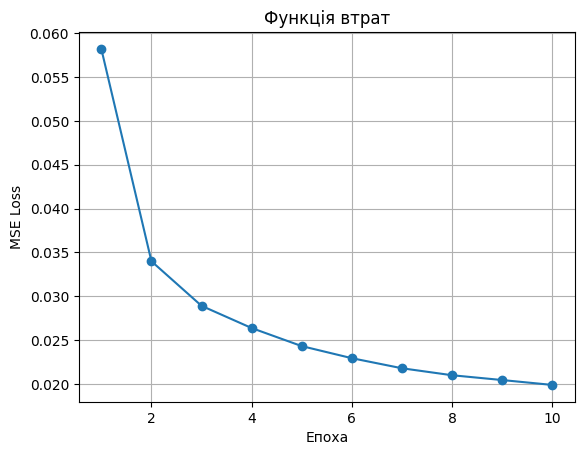

In [9]:
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title("Функція втрат")
plt.xlabel("Епоха")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

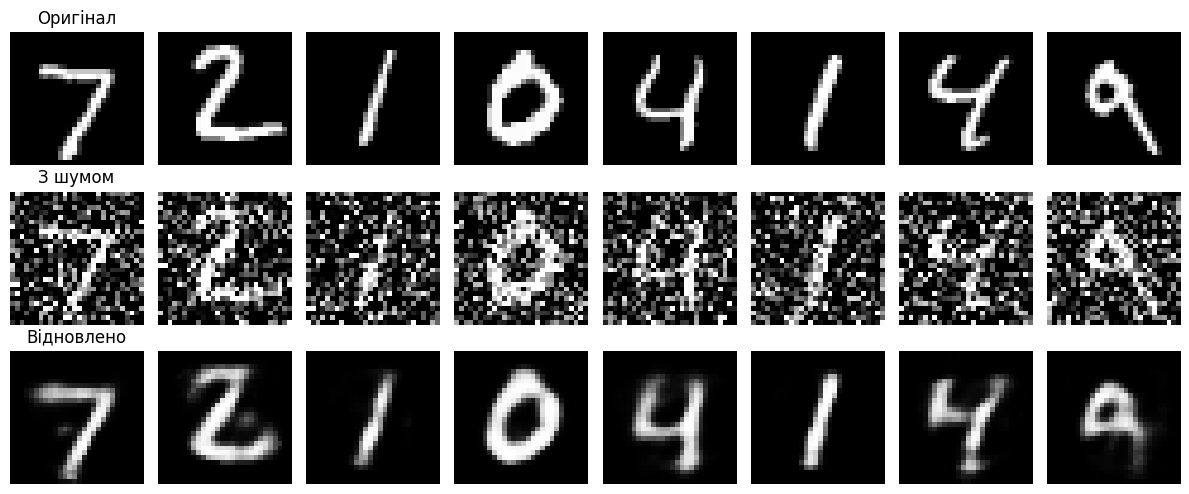

In [10]:
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    noisy_images = add_noise(images, noise_factor).to(device)
    outputs = model(noisy_images)

    images = images[:8]
    noisy_images = noisy_images[:8].cpu()
    outputs = outputs[:8].cpu()

    fig, axes = plt.subplots(3, 8, figsize=(12, 5))
    for i in range(8):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, 0].set_title("Оригінал")

        axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, 0].set_title("З шумом")

        axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
        axes[2, i].axis('off')
        axes[2, 0].set_title("Відновлено")

    plt.tight_layout()
    plt.show()

Висновок: У рамках лабораторної роботи було реалізовано автокодувальник для розпізнавання зображень рукописних цифр, до яких було додано гаусовий шум. За допомогою бібліотеки PyTorch побудовано модель, що включає енкодер і декодер, і навчалася відновлювати оригінальні (чисті) зображення з зашумлених вхідних даних.

Модель успішно пройшла навчання на модифікованому датасеті MNIST з доданим шумом, що дало змогу оцінити її здатність до реконструкції зображень. Під час навчання спостерігалося поступове зниження функції втрат, що свідчить про успішне навчання. Візуалізація результатів (зашумлене → очищене → оригінал) показала, що автокодувальник якісно відновлює вхідні дані, зберігаючи основні риси цифр.

Таким чином, розроблена модель може слугувати ефективним інструментом для попередньої обробки зображень у завданнях комп’ютерного зору, де вхідні дані мають шум чи інші спотворення.

Хочеш, щоб я оформив це як частину звіту або додав пояснення до графіків?
